In [1]:
%load_ext autoreload
%autoreload 2

from src.util import load_coauthor_nx, ddir, fn_nodes, fn_statoids

import community
import networkx as nx
from operator import itemgetter
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import skbio.diversity.alpha as b
import math
import random

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn import preprocessing
import numpy as np

In [2]:
random.seed(201010)
(G, nodes) = load_coauthor_nx() # abstracted into src

N nodes 361 ; N not nodes: 368
Proportion who did not coauthor 50.48010973936899
Name: 
Type: Graph
Number of nodes: 361
Number of edges: 463
Average degree:   2.5651


## Communities

In [3]:
# Read data
nodes_df = pd.read_csv(fn_nodes)
statoids = pd.read_csv(fn_statoids)
statoids = area_dict = dict(zip(statoids.DL, statoids.Country))

fn_spp = ddir + '2019-05-23-Apoidea world consensus file Sorted by name 2019 describers_2.0-denormalised.csv'
spp = pd.read_csv(fn_spp)[["idx", "full.name.of.describer.n"]]
spp = spp[spp.duplicated(subset="idx", keep=False)]             # keep only those with >1 authors

In [4]:
# Add module information
communities = community.best_partition(G, random_state=20100)  # https://python-louvain.readthedocs.io/en/latest/api.html
nx.set_node_attributes(G, communities, 'modularity')

In [5]:
G.nodes["Michael Scott Engel"]

{'country_of_residence': 'US',
 'degree': 30,
 'betweenness': 0.15170431250275676,
 'eigenvector': 0.4607013143210458,
 'modularity': 0}

In [6]:
# Function to get highest eigenvector centrality from each module
# module_number refers to the original module number
def get_highest_eigen_in_module(module_number):

    module = [n for n in G.nodes() if G.nodes[n]['modularity'] == module_number]

    print("Number of nodes: ", len(set(module)), " in module ", module_number, "\n")

    # Then create a dictionary of the eigenvector centralities of those nodes
    module_eigenvector = {n:G.nodes[n]['eigenvector'] for n in module}

    # Then sort that dictionary and print the first 5 results
    module_sorted_by_eigenvector = sorted(module_eigenvector.items(), key=itemgetter(1), reverse=True)
    print("Modularity Sorted by Eigenvector Centrality:")
    for node in module_sorted_by_eigenvector[:10]:
        print(node[0], "| ", node[1], " | ", G.nodes[node[0]]['country_of_residence'])
        
    print("\n\n")

In [7]:
# Test the function on module 0
get_highest_eigen_in_module(0)

Number of nodes:  46  in module  0 

Modularity Sorted by Eigenvector Centrality:
Michael Scott Engel |  0.4607013143210458  |  US
Terry L. Griswold |  0.32146051380748536  |  US
Victor Hugo Gonzalez [Betancourt] |  0.29420394689460644  |  US
Ricardo Ayala Barajas |  0.19620102130148936  |  MX
Ismael Alejandro Hinojosa-Díaz |  0.1845644245423236  |  US
John Stoskopf Ascher |  0.1697520309963212  |  US
Molly Greer Rightmyer |  0.14119439831030106  |  US
Mark Amidon Deyrup |  0.12334089443215683  |  US
Allan Henry Smith-Pardo |  0.10826750398308012  |  US
Abdulaziz S. Alqarni |  0.1074778533950178  |  SA





In [8]:
# Create dictionary of module (key) and authors (value)

modularity = {}                            # Create a new, empty dictionary

for k, v in communities.items():           # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k]                # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k)            # Append a name to the list for a modularity class the code has already seen


# Create counter of countries (value) for each module (key)

countries = {}
counter = 0
for k, v in modularity.items():            # Loop through the new dictionary
    counter = counter + len(v)
    country_li = []
    for i in range(0, len(v)):
        country = nodes_df[nodes_df['full.name.of.describer.n'] == v[i]]['residence.country.describer.n'].values[0]
        country = str.split(country, "; ")
        country_li = country_li + [country[0]]
    countries[k] = Counter(country_li)

print("\n In total, ", counter, " authors/ nodes.")


 In total,  361  authors/ nodes.


In [9]:
# Count number of modules

print(len(modularity), " modules")    # number of modules

52  modules


In [10]:
# Get a dataframe of module (index) and subgraph (0 column)

subgraphs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

def get_subgraph(node_name):
    subgraph_idx = -1
    
    for i in range(0, len(subgraphs)):
        if (node_name in list(subgraphs[i])):
            subgraph_idx = i
    
    return subgraph_idx
          
community_subgraph = pd.DataFrame.from_dict({key:get_subgraph(value[0]) for (key,value) in modularity.items()}, orient='index')

In [11]:
# Get number of species for each module as a dataframe

N_species = {}
for i, sg in enumerate(modularity.items()):
    spp_li = []
    for auth in sg[1]:
        spp_li = spp_li + list(spp[spp['full.name.of.describer.n']==auth]['idx'].values)
        
    N_species[i] = len(set(spp_li))
N_species = pd.DataFrame.from_dict(N_species, orient="index")
N_species.columns = ["N_species"]

In [12]:
# Convert dictionary countries to pandas.DataFrame countries_df
countries_df = pd.DataFrame.from_dict(countries, orient='index')
cols = list(countries_df.columns.values) 

# Shift column [unknown] to end
cols.pop(cols.index('[unknown]'))
cols_rearranged = cols + ['[unknown]']
countries_df = countries_df[cols_rearranged]

# Sort by index
countries_df = countries_df.sort_index()

In [13]:
# Get number of authors and countries as a dataframe for each module

countries_summary1 = countries_df.sum(axis=1)   # count number of authors in each module
countries_summary2 = countries_df.count(axis=1) # count number of countries in each module

# Combine all dataframes (N authors, N countries, Subgraph, N species)

countries_summary = pd.concat([countries_summary1, countries_summary2], axis=1) 
countries_summary = countries_summary.merge(community_subgraph, "outer", left_index=True, right_index=True)
countries_summary = countries_summary.merge(N_species, "outer", left_index=True, right_index=True)
countries_summary.columns = ['N_authors', 'N_countries', 'Subgraph_id', 'N_species']
countries_summary.index.names = ['Modules']

# Create a new column called "idx" (which will be the way the dataframe is sorted later for labels)

# It is sorted by Subgraph_id and N_authors
countries_summary = countries_summary.sort_values(['Subgraph_id', 'N_authors'], ascending=[True,  False])
countries_summary['idx'] = range(0, len(countries_summary))
# Create label
countries['lab'] = ' [' + countries_summary['N_authors'].astype(int).astype(str) + ',' +\
    countries_summary['N_countries'].astype(int).astype(str) + "," +\
    countries_summary['N_species'].astype(int).astype(str) + '] ' +\
    "id" + countries_summary.idx.astype(str).str.pad(2, "left", "0") + " / " +\
    "S" + countries_summary['Subgraph_id'].astype(str).str.pad(2, "left", "0")

# Sort by index and save idx
countries_summary = countries_summary.sort_index()
idx = countries_summary.idx.values
countries_summary = countries_summary.sort_values('idx')

In [14]:
# Summary stats for ALL subgraphs
countries_summary.agg({'N_authors': ['median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max']})

,N_authors,N_countries
median,2.0,1.0
min,2.0,1.0
max,46.0,12.0


In [15]:
# Summary stats for subgraph 1
countries_summary.groupby('Subgraph_id')\
                 .agg({'N_authors': ['median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max', 'count']})\
                 .iloc[0] # for subgraph 1

N_authors    median    21.0
             min        7.0
             max       46.0
N_countries  median     7.0
             min        2.0
             max       12.0
             count     11.0
Name: 0, dtype: float64

All of the subgraphs only have one cluster, but the largest one has 12 clusters.

In [16]:
# Get proportions
countries_prop = countries_df.apply(lambda r: round(r/r.sum()*100, 1), axis=1)
countries_prop.index = idx
countries_prop = countries_prop.sort_index()
countries_prop.index = countries['lab']

In [17]:
# Get full country name from abbreviated form
def parse_countries(country):
    if country == "[unknown]":
        return country
    else:
        return statoids[country]
countries_prop.columns = [parse_countries(x) for x in countries_prop.columns]
countries_prop.columns = countries_prop.columns + " [" + countries_prop.count().astype(str) + "]"

[Text(113.99999999999999, 0.5, 'Countries'),
 Text(0.5, 96.0, '\nProportion of country from each module (%)')]

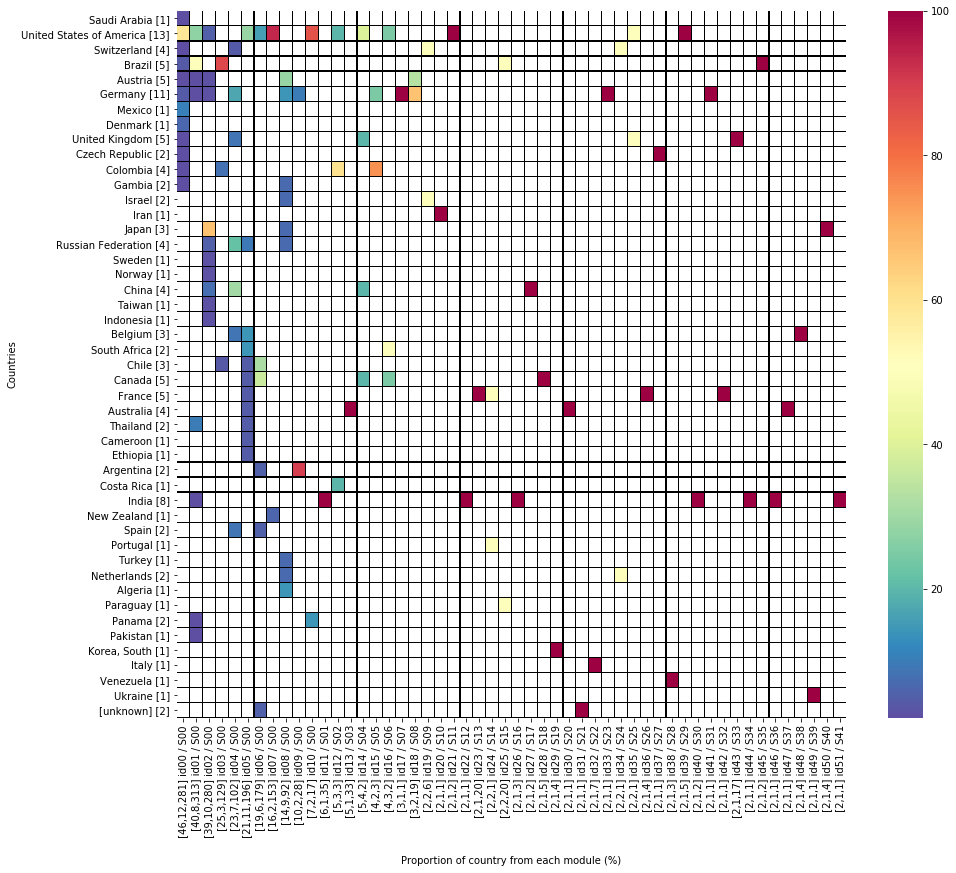

In [18]:
# Plot graph
countries_prop_t = countries_prop.transpose(copy=True)
countries_prop_t[countries_prop_t.columns] = countries_prop_t[countries_prop_t.columns].replace({0: float('nan')})
plt.figure(figsize=(15, 13))
ax = sns.heatmap(countries_prop_t, cmap=plt.get_cmap("Spectral_r"), linecolor="k", linewidths=0.1)
ax.set(xlabel='\nProportion of country from each module (%)', ylabel='Countries')

In [19]:
countries_prop.iloc[3][countries_prop.iloc[3].notnull()]

Brazil [5]      88.0
Colombia [4]     8.0
Chile [3]        4.0
Name:  [25,3,129] id03 / S00, dtype: float64

In [20]:
# Calculate diversity indices

indices_simpsons = []
indices_shannon = []

for i, idx in enumerate(countries_prop.index):
    country_counts = [x for x in countries_prop.iloc[i].values if not math.isnan(x)]
    
    # indices = countries_prop.iloc[i][countries_prop.iloc[i].notna()].values
    indices_simpsons =  indices_simpsons + [b.simpson(country_counts)]
    indices_shannon =  indices_shannon + [b.shannon(country_counts)]

countries_summary['simpson'] = indices_simpsons
countries_summary['shannon'] = indices_shannon

In [21]:
countries_summary_original = countries_summary.copy(deep=True)
countries_summary_original

,N_authors,N_countries,Subgraph_id,N_species,idx,simpson,shannon
Modules,,,,,,,
0,46.0,12,0,281,0,0.632973,2.293537
19,40.0,8,0,313,1,0.661250,2.009620
3,39.0,10,0,280,2,0.541759,1.932851
9,25.0,3,0,129,3,0.217600,0.639556
11,23.0,7,0,102,4,0.805274,2.555295
4,21.0,11,0,196,5,0.853036,3.108560
15,19.0,6,0,179,6,0.731866,2.149642
10,16.0,2,0,153,7,0.116312,0.335334
16,14.0,9,0,92,8,0.846446,2.947627


In [22]:
# countries_summary = countries_summary_original.copy(deep=True)

In [23]:
# Scale values by min max for PCA

cols = ['N_authors', 'N_countries', 'N_species', 'simpson']
x = countries_summary[cols].values #returns a numpy array
scaler = preprocessing.StandardScaler()
countries_summary_scaled = pd.DataFrame(scaler.fit_transform(x))

In [24]:
# Perform PCA

pca = PCA(n_components=2, svd_solver='full')
pca.fit(countries_summary_scaled)
pca.values = pca.transform(countries_summary_scaled)
pca.values = pd.DataFrame(pca.values, columns=['PC1', 'PC2'])

var = pca.explained_variance_ratio_
countries_summary = countries_summary.reset_index().merge(pca.values, left_index=True, right_index=True)

In [25]:
# Perform DBSCAN
cluster = KMeans(n_clusters=5, random_state=22).fit(countries_summary[['PC1', 'PC2']].values)
countries_summary['KMeans group'] = cluster.labels_ + 1
countries_summary.loc[countries_summary['KMeans group'] == 0, 'KMeans group'] = "Ungrouped"

In [26]:
countries_summary

,Modules,N_authors,N_countries,Subgraph_id,N_species,idx,simpson,shannon,PC1,PC2,KMeans group
0,0,46.0,12,0,281,0,0.632973,2.293537,6.016215,-1.165436,4
1,19,40.0,8,0,313,1,0.661250,2.009620,5.203761,-1.208814,4
2,3,39.0,10,0,280,2,0.541759,1.932851,5.140841,-1.241105,4
3,9,25.0,3,0,129,3,0.217600,0.639556,1.617620,-1.125258,1
4,11,23.0,7,0,102,4,0.805274,2.555295,2.978481,0.918714,2
5,4,21.0,11,0,196,5,0.853036,3.108560,4.338611,0.801839,2
6,15,19.0,6,0,179,6,0.731866,2.149642,2.987868,0.407086,2
7,10,16.0,2,0,153,7,0.116312,0.335334,0.984508,-1.243488,1
8,16,14.0,9,0,92,8,0.846446,2.947627,2.906681,1.514482,2
9,6,10.0,2,0,28,9,0.180000,0.468996,-0.048875,-0.170585,5


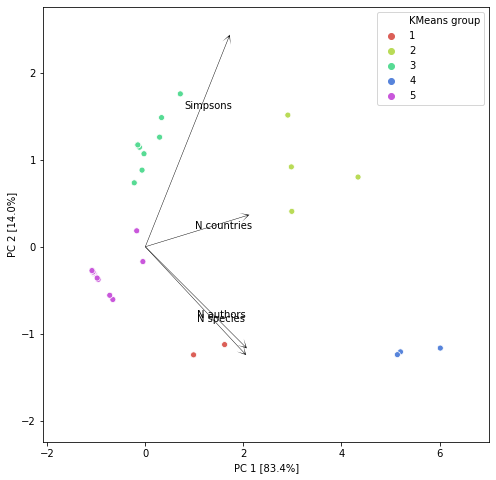

In [27]:
# Get the PCA components (loadings)
PCs = pca.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(8, 8))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:]*4, PCs[1,:]*3, 
           angles='xy', scale_units='xy', scale=1, 
           width = 0.001, headwidth = 20, headlength = 20)

# Add labels based on feature names (here just numbers)
feature_names = ['N authors', 'N countries', 'N species', 'Simpsons']
for i,j,z in zip(PCs[1,:]*2, PCs[0,:]*3, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# # Add unit circle
# circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
# plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
# plt.axis('equal')
plt.xlim([countries_summary['PC1'].min()-1, countries_summary['PC1'].max()+1])
plt.ylim([countries_summary['PC2'].min()-1, countries_summary['PC2'].max()+1])

# Plot value
n_colours = len(countries_summary['KMeans group'].unique())
sns.scatterplot(countries_summary['PC1'], countries_summary['PC2'],  
                hue=countries_summary['KMeans group'], palette=sns.color_palette("hls", n_colours), legend="brief")

# Label axes
xlab = "PC 1 [" + str(round(var[0]*100, 1)) + "%]"
plt.xlabel(xlab)
ylab = "PC 2 [" + str(round(var[1]*100, 1)) + "%]"
plt.ylabel(ylab)

plt.show()

In [28]:
countries_summary.agg({'N_authors': ['count', 'median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max'],
                       'N_species': ['median', 'min', 'max'],
                       'simpson': ['median', 'min', 'max']})

,N_authors,N_countries,N_species,simpson
count,52.0,NaN,NaN,NaN
max,46.0,12.0,313.0,0.853036
median,2.0,1.0,3.0,0.000000
min,2.0,1.0,1.0,0.000000


In [29]:
# Summary stats for subgraph 1
countries_summary.groupby('KMeans group')\
                 .agg({'N_authors': ['count', 'median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max'],
                       'N_species': ['median', 'min', 'max'],
                       'simpson': ['median', 'min', 'max']})

# group 1: high authors, low countries, high species, low simpsons = not international, contribute to many species
# group 2: mid authors, mid countries, mid species, high simpsons = international, mid-sized
# group 3: low authors, low countries, low species, mid simpsons = international, small-sized
# group 4: high authors, high countries, high species, high simpsons = international, big-sized
# group 5: low authors, low countries, low species, low simpsons = not international, contribute to few species

N_authors                    N_countries         N_species       \
                 count median   min   max      median min max    median  min   
KMeans group                                                                   
1                    2   20.5  16.0  25.0         2.5   2   3     141.0  129   
2                    4   20.0  14.0  23.0         8.0   6  11     140.5   92   
3                   10    2.5   2.0   5.0         2.0   2   4       2.5    1   
4                    3   40.0  39.0  46.0        10.0   8  12     281.0  280   
5                   33    2.0   2.0  10.0         1.0   1   2       2.0    1   

                    simpson                      
              max    median       min       max  
KMeans group                                     
1             153  0.166956  0.116312  0.217600  
2             196  0.825860  0.731866  0.853036  
3              20  0.500000  0.375000  0.720000  
4             313  0.632973  0.541759  0.661250  
5              35  0.000000  0.000000  0.245102

In [30]:
countries_summary.iloc[3]

Modules           9.000000
N_authors        25.000000
N_countries       3.000000
Subgraph_id       0.000000
N_species       129.000000
idx               3.000000
simpson           0.217600
shannon           0.639556
PC1               1.617620
PC2              -1.125258
KMeans group      1.000000
Name: 3, dtype: float64

In [31]:
spp_li = []
counter = 0
for i, sg in enumerate(countries_summary[countries_summary.N_countries>=3].index.values):
    for auth in modularity[sg]:
        spp_li = spp_li + list(spp[spp['full.name.of.describer.n']==auth]['idx'].values)
    counter += 1
spp_li = len(set(spp_li))
n_auth = countries_summary[countries_summary.N_countries>=3]['N_authors'].sum()
from_subgraphs = countries_summary[countries_summary.N_countries>=3]['Subgraph_id'].unique()
print("Authors with >=3 countries accounted for", spp_li, "species for ", counter, " clusters/modules and with", 
      n_auth, "authors from subgraphs", from_subgraphs, "( n=", len(from_subgraphs), ").")

Authors with >=3 countries accounted for 860 species for  11  clusters/modules and with 241.0 authors from subgraphs [0 2 4 6] ( n= 4 ).


In [32]:
# Clusters with only 2 countries
print(len(countries_summary[countries_summary.N_countries==2]))
# Clusters with only 1 country
print(len(countries_summary[countries_summary.N_countries==1]))
# Clusters with only 1 country and 2 authors
print(len(countries_summary[(countries_summary.N_countries==1) & (countries_summary.N_authors <=2)]))

10
31
28


In [33]:
print(countries_summary[countries_summary['KMeans group']==1], "\n")

# Brazil group and US/New Zealand group ("old")
print(modularity[9], "\n")
print(modularity[10])

   Modules  N_authors  N_countries  Subgraph_id  N_species  idx   simpson  \
3        9       25.0            3            0        129    3  0.217600   
7       10       16.0            2            0        153    7  0.116312   

    shannon       PC1       PC2  KMeans group  
3  0.639556  1.617620 -1.125258             1  
7  0.335334  0.984508 -1.243488             1   

['Alexsander A. Azevedo', 'Antonio José Camillo Aguiar', 'Beatriz Woiski Teixeira Coelho', 'Danny Vélez', 'Eduardo Andrade Botelho de Almeida', 'Fabrício R. Santos', 'Favízia Freitas de Oliveira', 'Felipe V. Freitas', 'Felipe Vivallo [Felipe Rodrigo Vivallo Martínez]', 'Fernando Amaral da Silveira', 'Fernando César Vieira Zanella', 'Fernando Fernández', 'Gabriel Augusto Rodrigues de Melo', 'José Eustáquio Santos Júnior', 'Kelli dos Santos Ramos', 'Leandro Mattos Santos', 'Luiz R. R. Faria', 'Marcio Luiz de Oliveira', 'Marco Antônio Costa', 'Nadia S. Gibran', 'Paola Marchi', 'Roderic B. Martines', 'Rodrigo Barbosa G

In [34]:
countries_df_m2 = countries_df.loc[countries_df.count(axis=1) > 2] # countries with <=2
print(countries_df_m2.count(axis=0).sort_values(ascending=False)[0:10])

countries_df_l2 = countries_df.loc[countries_df.count(axis=1) < 2] # countries with <=2
print(countries_df_l2.count(axis=0).sort_values(ascending=False)[0:10])

US    8
GM    5
CA    4
AU    4
RS    4
CI    3
BR    3
CH    3
UK    3
CO    3
dtype: int64
IN    7
FR    3
AS    3
GM    3
US    2
EZ    1
BE    1
UP    1
CA    1
JA    1
dtype: int64


In [35]:
countries_summary.sort_values('idx')

,Modules,N_authors,N_countries,Subgraph_id,N_species,idx,simpson,shannon,PC1,PC2,KMeans group
0,0,46.0,12,0,281,0,0.632973,2.293537,6.016215,-1.165436,4
1,19,40.0,8,0,313,1,0.661250,2.009620,5.203761,-1.208814,4
2,3,39.0,10,0,280,2,0.541759,1.932851,5.140841,-1.241105,4
3,9,25.0,3,0,129,3,0.217600,0.639556,1.617620,-1.125258,1
4,11,23.0,7,0,102,4,0.805274,2.555295,2.978481,0.918714,2
5,4,21.0,11,0,196,5,0.853036,3.108560,4.338611,0.801839,2
6,15,19.0,6,0,179,6,0.731866,2.149642,2.987868,0.407086,2
7,10,16.0,2,0,153,7,0.116312,0.335334,0.984508,-1.243488,1
8,16,14.0,9,0,92,8,0.846446,2.947627,2.906681,1.514482,2
9,6,10.0,2,0,28,9,0.180000,0.468996,-0.048875,-0.170585,5


[Text(0, 0.5, 'Number of authors'), Text(0.5, 0, '\n Number of countries')]

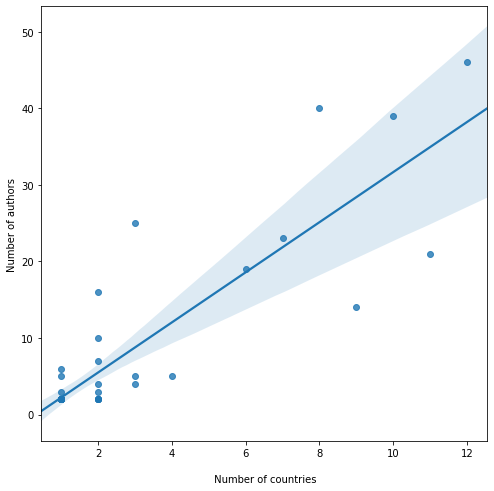

In [36]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(countries_summary['N_countries'], countries_summary['N_authors'])
ax.set(xlabel='\n Number of countries', 
       ylabel='Number of authors')

In [37]:
[get_highest_eigen_in_module(x) for x in countries_summary[countries_summary.N_authors>=10].index.values]

Number of nodes:  46  in module  0 

Modularity Sorted by Eigenvector Centrality:
Michael Scott Engel |  0.4607013143210458  |  US
Terry L. Griswold |  0.32146051380748536  |  US
Victor Hugo Gonzalez [Betancourt] |  0.29420394689460644  |  US
Ricardo Ayala Barajas |  0.19620102130148936  |  MX
Ismael Alejandro Hinojosa-Díaz |  0.1845644245423236  |  US
John Stoskopf Ascher |  0.1697520309963212  |  US
Molly Greer Rightmyer |  0.14119439831030106  |  US
Mark Amidon Deyrup |  0.12334089443215683  |  US
Allan Henry Smith-Pardo |  0.10826750398308012  |  US
Abdulaziz S. Alqarni |  0.1074778533950178  |  SA



Number of nodes:  2  in module  1 

Modularity Sorted by Eigenvector Centrality:
Achik Dorchin |  3.262429847484653e-23  |  IS
Christophe J. Praz |  3.262429847484653e-23  |  SZ



Number of nodes:  2  in module  2 

Modularity Sorted by Eigenvector Centrality:
Ahmad Nadimi |  3.262429847484653e-23  |  IR
Ali Asghar Talebi |  3.262429847484653e-23  |  IR



Number of nodes:  39  in mo

[None, None, None, None, None, None, None, None, None, None]